# Part 1: Regression Trees 
[decision tree in scikit learn]("http://scikit-learn.org/stable/modules/tree.html")

# Building a regression tree by hand
1.  Read the data into a Pandas DataFrame
2.  Explore the data by sorting, ploting, or split-apply-combine ()aka group_by 
3.  Decided which feature is the most important predictor, and use that to create your firist spliting rule. 

 - Only binary splits are allowed.

4.  After making your first split, spit your DataFrame into two parts, and then explore each part to figure out what other splits to make. 
5.  Stop makring splits once your are convinced that it strikes a good balance between underfitting and overfitting 

 - Your goal is to build a model that generalizes well
 - You are allowed to split on the same variable multiple times! 

6.  Draw your tree, labeling the leaves with the mean price for the observations in that region.

 - Make sure nothing is backwards: You follow the **left branch** if the rule is true, and the **right branch** if the rule is false.

# How does a computer build a regression tree?
**Ideal approach**: Consider every possible partition of the feature space(computationally infeasible)
**Good enough** approach: recursive binary splitting
1. Begin at the top of the tree
2. For **every feature**, examine **every possible cutpoint**, and choose the feature and cutpoint such that the resulting tree has the lowest possible mean squared error(MSE). Make that split
3. Examine the two resulting regions, and again make a **single split** (in one of the regions) to minimize the MSE
4. Keep repeating step 3 until a **stopping criterion** is met:
- maximum tree depth
- minimum number of observations in a leaf
## Demo: Choosing the ideal cutpoint for a given feature

In [1]:
import pandas as pd
url = "https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_train.csv"
train = pd.read_csv(url)

In [2]:
train['prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [3]:
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.9819859959835

In [4]:
def mileage_split(miles):
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction']=np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [5]:
mileage_split(50000)

3984.0917425414564

In [6]:
mileage_split(100000)

3530.1465300762688

In [7]:
mileage_range=range(train.miles.min(), train.miles.max())
RMSE = [mileage_split(miles) for miles in mileage_range]

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['font.size']=14

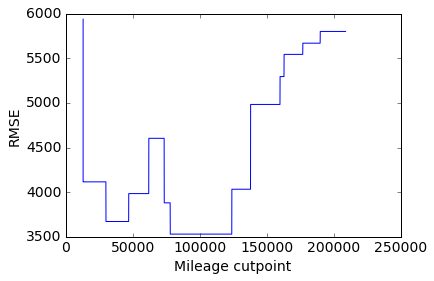

In [9]:
plt.plot(mileage_range, RMSE)
plt.xlabel('Mileage cutpoint')
plt.ylabel('RMSE')

**Recap**: Before every split, this process is repeated for every feature, and the feature and cutpoint that produces the lowest MSE is chosen. 

## Building a regression tree in scikit-learn

In [10]:
train['vtype'] = train.vtype.map({"car":0, "truck":1})
feature_cols = ['year', 'miles', 'doors', 'vtype']
X = train[feature_cols]
y = train.price

In [11]:
from sklearn.tree import DecisionTreeRegressor
treereg = DecisionTreeRegressor(random_state=1)
treereg

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [12]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
np.mean(np.sqrt(-scores))

3107.1428571428573

In [13]:
scores

array([-64000000., -64000000., -12250000., -12250000., -16000000.,
       -25000000.,  -1000000.,  -1000000.,  -2890000.,  -1210000.,
         -250000., -16000000.,   -250000.,  -2890000.])

## What happens when we grow a tree too deep?
The **training error** continues to go down as the tree size increase(due to overfitting), but the lowest **cross-validation error** occurs for a tree with 3 leaves. 

## Tuning a regression tree
Let's try to reduce the RMSE by tuning the **max_depth** parameter:


In [14]:
treereg = DecisionTreeRegressor(max_depth = 1, random_state=1)
scores = cross_val_score(treereg, X,y, cv=14, scoring="mean_squared_error")
np.mean(np.sqrt(-scores))

4050.1443001442999

In [15]:
max_depth_range = range(1,8)
RMSE_scores=[]
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X,y, cv=14, scoring="mean_squared_error")
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

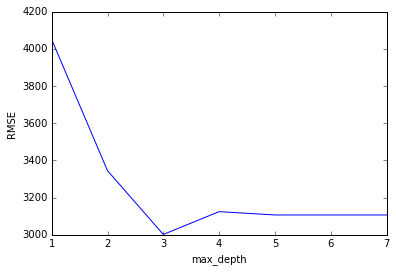

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

In [17]:
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [18]:
pd.DataFrame({'feature':feature_cols, "importance":treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


## Creating a tree diagram


In [19]:
from sklearn.tree import export_graphviz
export_graphviz(treereg, out_file='tree.dot', feature_names=feature_cols)

## Making prediction for the testing data

In [20]:
url = 'https://raw.githubusercontent.com/justmarkham/DAT8/master/data/vehicles_test.csv'
test = pd.read_csv(url)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [21]:
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)
y_pred

array([  4000.,   5000.,  13500.])

In [22]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

# Part 2: Classification trees

## Comparing regression trees and classifcation tree
**regression trees**                     | **classification trees**
------------------                       | --------------------
predict a continuous response            | predict a categorical response
predict using mean response of each leaf | predict using most commonly occuring class of each leaf
splits are chosen to minimize MSE | splits are chosen to minimize Gini index (discuss below)

## Splitting criteria for classification trees
Common options for the splitting criteria: 
- **classification error rate**: fraction of training observations in a region that don't belong to the most common class
- **Gini index:** measure of total variance across classes in a gregion 

### Example of classification error rate
Pretend we are predicting whether someone buys an iPhone or an Android:
- At a particular node, there are **25 observations**(phone buyers), of whom **10 bought iPhone and 15 bought Androids**. 
- Since the majority class is **Android,** that's our prediction for all 25 observations, and thus the classification error rate is **10/25=40%**. 

Our goal is making splits is to **reduce the classification error reate** Let's try splitting on gender:

- **Males**: 2 iPhones and 12 Androids, thus the predicted class is Android
- **Female**: 8 iPhones and 3 Androids, thus the predicted class is iPhone
- Classification error rate after this split would be 5/25=20%

Compare that with a split on age:
- **30 or younger**: 4 iPhones and 8 Androids, thus the predicted cclass is Android
- **31 or older**: 6 iPhones and 7 Androids, thus the predicted class is Android
- Classification error rate after this split would be 10/25 = 40%

This decision tree algorithm will try **every possible split across all features**, and choose the split that **reduces the error rate the most**.

### Example of Gini index
Calculate the Gini index before making a split: 
- The **maximum value** of the Gini index is 0.5, and occurs when the classes are prefectly balanced in a node. 
- The **minimum value** of the Gini index is 0, and occurs when there is only one class represented in a node. 
- A node with a lower Gini index is said to be more "pure". 
Evaluating the split on **gender** using Gini index: 
                                Males: 1−(2/14)^2−(12/14)^2=0.24
                                Females: 1−(8/11)^2−(3/11)^2=0.40
                                Weighted Average: 0.24(14/25)+0.40(11/25)=0.3
Again, the decision tree algorithm will try **every possible split**, and will choose the split that **reduces the Gini index(and thus the "node purity") the most**. 

## Comparing classification error rate and Gini index
- Gini index is generally preferred because it will make splits that **increase node purity**, even if that split does not change the classification error rate. 
- Node purity is important because we're interested in the **class proportions** in each region, since that's how we calculate the **predicted probability** of each class. 
- scikit-learn's default splitting criteria for classification is Gini index.

Note: There is another common spliting criteria called cross-entropy. It is numerically similar to Gini index, but slower to complete, thus it's not as popular as Gini index. (check my own note to see how entropy works)

## Building a classification tree in scikit-learn


In [23]:
url="https://raw.githubusercontent.com/justmarkham/DAT8/master/data/titanic.csv"
titanic=pd.read_csv(url)

In [24]:
titanic['Sex']=titanic.Sex.map({'female':0, 'male':1})

In [25]:
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [26]:
titanic.Age.fillna(titanic.Age.median(), inplace=True)

In [27]:
embarked_dummies=pd.get_dummies(titanic.Embarked,prefix='Embarked')
embarked_dummies.drop(embarked_dummies.columns[0],axis=1, inplace=True)

In [28]:
titanic = pd.concat([titanic, embarked_dummies],axis=1)

In [29]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0.0,1.0


In [30]:
feature_cols = ['Pclass', 'Sex', 'Age','Embarked_Q','Embarked_S']
X = titanic[feature_cols]
y = titanic.Survived

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
treefit = DecisionTreeClassifier(max_depth=3, random_state=1)
treefit.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [32]:
from sklearn import tree
from sklearn.externals.six import StringIO
import pydot 
tree.export_graphviz(treefit, out_file='tree.dot',feature_names=feature_cols)

Couldn't import dot_parser, loading of dot files will not be possible.


In [33]:
pd.DataFrame({'feature':feature_cols, 'important':treefit.feature_importances_})

,feature,important
0,Pclass,0.242664
1,Sex,0.655584
2,Age,0.064494
3,Embarked_Q,0.000000
4,Embarked_S,0.037258


# Part 3: Comparing decision trees with other model
### Advantages of decision trees:
- Can be used for regression or classification
- Can be displayed graphically
- Highly interpretable
- Can be specified as a series of rules, and more closely approximate human decision-making than other models
- Prediction is fast
- Feature don't need scaling
- Automatically learns feature interactions
- Tends to ignore irrelevant features
- Non-parametric(will outperform linear models if relationship between features and response is highly non-linear)